<center><font size="6"><b><i>Anime VS Cartoon VS Human:</b></i></font></center>
<center><font size="5"><i>Image Clustering and Generating</i></font></center>
<center>by Chao Xu</center>

<h2>I: Introduction</h2>

My midterm project did handwritten math symbols classification in , . For my final project, I want to try image clustering using SOM and image generation using GAN.

Dataset: <b>Anime VS Cartoon VS Human</b> (https://www.kaggle.com/datasets/hadiepratamatulili/anime-vs-cartoon-vs-human)

With this dataset, I will use different deep learning techniques to build two different models. The main steps are as follows:
- Split data into different folders and load data using tf.data.Dataset API.
- Analyze and preprocess the data to prepare for the training.
- Use <b>SOM</b> to build a model for image clustering.
- Use <b>Conditional GAN</b> to generate images with different labels.
- Use <b>Callbacks</b> for training the model
- Save the GAN model and deploy the model with <b>Flask<b>.

To see my project on <b>GitHub</b>: https://github.com/Lilacbibi/CISB62_final<br>
To see my model deployment on <b>Render</b>: https://gan-model-deployment-flask.onrender.com

<h2>II: Load, Preprocess, and Analyze Data

<h3>Load and Preprocess Data

<h4>Import libraries and set gpu

In [1]:
#Import libraries for loading, analyzing, and preprosessing data
import numpy as np
import os
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Make sure the GPU is availabe difficult
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
#Limit the GPU memory growth so that the runtime initialization will not allocate all GPU memory on the device.
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

<h4>Load and split data

In [4]:
#Set the path of the data folder
path = 'Data'

In [5]:
#Split the data into train and test
#!pip install split-folders
import splitfolders
splitfolders.ratio(path, output="Splitted_Data", seed=1001, ratio=(0.9, 0, 0.1)) 

Copying files: 8917 files [00:15, 592.35 files/s] 


In [5]:
#Create path for the train and test folder
train_directory = 'Splitted_Data/train'
test_directory = 'Splitted_Data/test'

<h4>Generate tf.data.Dataset (Create Dataset Pipeline)

In [6]:
#Generates tf.data.Dataset from image files in the train and test directory.
train = tf.keras.utils.image_dataset_from_directory(
    train_directory, label_mode='categorical', shuffle=True,
    image_size=(64, 64), seed=1001, batch_size=64)

test = tf.keras.utils.image_dataset_from_directory(
    test_directory, label_mode='categorical', shuffle=False,
    image_size=(64, 64), seed=1001, batch_size=64)

Found 8024 files belonging to 3 classes.
Found 893 files belonging to 3 classes.


<h3>Analyzing Data

<h4>Inspect the shape of data

In [7]:
#Use as_numpy_iterator to inspect the content of the dataset
train_iterator = train.as_numpy_iterator()

#while not train_iterator.finished:
    
#Use next() to grab batches from the dataset
batch = train_iterator.next()

#Show the shape of train data in a batch
print('The length of the batch:', len(batch))
print('The shape of the images in the batch:', batch[0].shape)
print('The shape of the labels in the batch:', batch[1].shape)
print('The sample label data:', batch[1][0])

The length of the batch: 2
The shape of the images in the batch: (64, 64, 64, 3)
The shape of the labels in the batch: (64, 3)
The sample label data: [0. 0. 1.]


- The length of the batch is 2, which means for each element, there is a image and a corresponding label.
- The first number 64 represents the batch size.
- The shape of the images represents the batch size, image size, and 3 channel.
- The shape of the labels (64, 3) represents the batch size and 3 categories as labels.
- The sample label data shows that it is a one-hot encoding format.

<h4>Put the image labels in a list

In [8]:
#Put the image labels in a list
labels = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
n_classes = len(labels)

print('There are', n_classes, 'classes in this dataset.')
print('The classes are:', labels)

There are 3 classes in this dataset.
The classes are: ['anime', 'cartoon', 'human']


<h4>Show some images with labels from the dataset

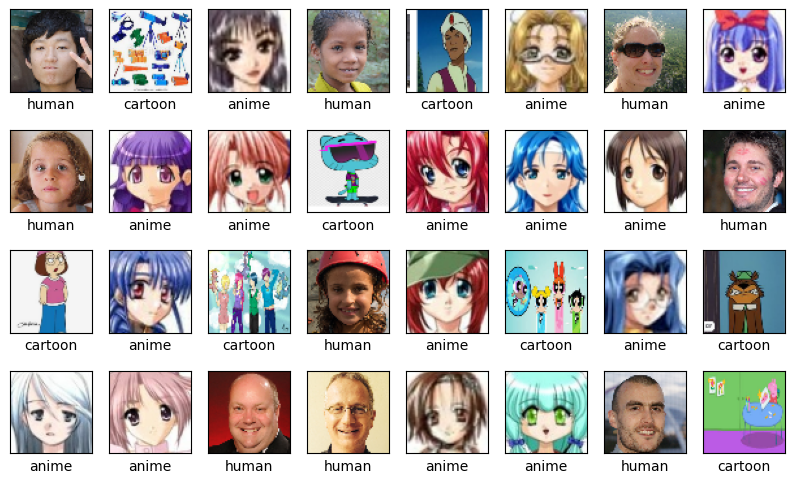

In [9]:
#Show some images with their labels in one train batch
plt.figure(figsize=(10,6))

for k in range(32):
    plt.subplot(4,8,k+1)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(batch[0][k].astype(int), cmap=plt.cm.gray)
    #Get the index of the maximum value (1) and change it to the actual label name
    plt.xlabel(labels[batch[1][k].argmax()], fontsize=10)

plt.show()

<h4>Show one sample image with histogram of pixel intensity

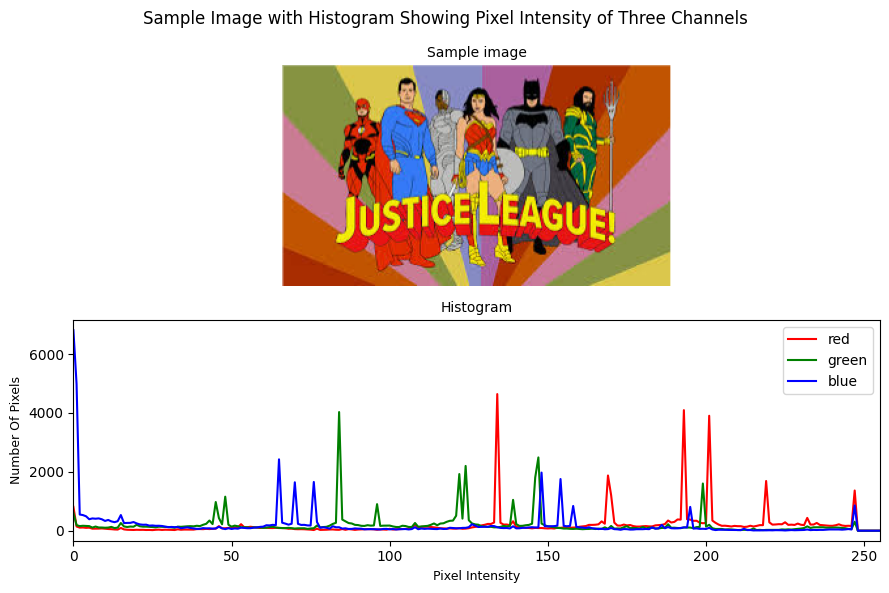

In [10]:
#Read sample image
sample_img = cv2.imread('Splitted_Data/train/cartoon/29 (6).png')
#Convert the channels from BGR to RGB
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (9,6))
red_hist = cv2.calcHist([sample_img], [0], None, [256], [0, 255])
green_hist = cv2.calcHist([sample_img], [1], None, [256], [0, 255])
blue_hist = cv2.calcHist([sample_img], [2], None, [256], [0, 255])

#Plot the image
plt.subplot(2, 1, 1)
plt.imshow(sample_img)
plt.title('Sample image', fontsize=10)
plt.axis('off')

#Plot the histogram of three channels
plt.subplot(2, 1, 2)
plt.plot(red_hist, color='r')
plt.plot(green_hist, color='g')
plt.plot(blue_hist, color='b')
plt.xlim([0, 255])
plt.title('Histogram', fontsize=10)

#Set title, labels, and legend
plt.suptitle("Sample Image with Histogram Showing Pixel Intensity of Three Channels")
plt.ylabel("Number Of Pixels", fontsize=9)
plt.xlabel("Pixel Intensity",fontsize=9)
plt.legend(labels=('red', 'green','blue'), loc="best")

plt.tight_layout()
plt.show()

<h2>III: Image Clustering Using SOM

<h4>Preprocess data

In [11]:
#Reshape the image data to an one-dimensional array
train_som = train.map(lambda X, y: (tf.reshape(X, [tf.shape(X)[0], -1]), y))

<h3>Create a SOM model class

In [12]:
#Create a SOM class
class SOM(object):

    #initialize properties
    def __init__(self, x_grid_size, y_grid_size,input_dim, sigma=.8,
                 learning_rate=0.5, random_seed=777):

        self.sigma = sigma
        self.learning_rate = learning_rate
        self.random_instance = np.random.RandomState(random_seed)
        self.weights = self.random_instance.uniform(-1, 1, (x_grid_size,
                                                            y_grid_size,
                                                            input_dim))

        self.activation_map = np.zeros((x_grid_size,y_grid_size))
        self.x_coordinates = np.arange(x_grid_size)
        self.y_coordinates = np.arange(y_grid_size)
        self.neighborhood = self.gaussian

    #Calculate learning rate and radius using decay function
    def _decay_function(self, decaying_variable, iteration_index, temperature):
        return (decaying_variable * np.exp(-(iteration_index) / temperature))

    #Return norm of the matrix
    def _norm(self,x):
        return np.linalg.norm(x)

    #Iterate samples
    def _activate(self,sample):
        grid_difference = np.subtract(sample, self.weights)
        iterator = np.nditer(self.activation_map, flags=['multi_index'])
        while not iterator.finished:
            self.activation_map[iterator.multi_index] = self._norm(
                                            grid_difference[iterator.multi_index])
            iterator.iternext()

    def activate(self,sample):
        self._activate(sample)
        return self.activation_map

    #Use gaussian to calculate neighborhood 
    def gaussian(self,center,sigma):
        x_center = center[0]
        y_center = center[1]
        variance = sigma*sigma
        gaussian_x = np.exp(-np.power(self.x_coordinates-x_center,2)/(2*variance))
        gaussian_y = np.exp(-np.power(self.y_coordinates-y_center,2)/(2*variance))
        gaussian_neighborhood = np.outer(gaussian_x,gaussian_y)
        return gaussian_neighborhood

    #Calculate location of best matching unit (winner)
    def calculate_winner(self,sample):
        self._activate(sample)
        winner_arg = self.activation_map.argmin()
        winner_coordinates =  np.unravel_index(winner_arg, self.activation_map.shape)
        return winner_coordinates

    #update all the weights
    def update(self, sample, winner_coordinates, iteration_index):
        eta = self._decay_function(self.learning_rate, iteration_index, self.temperature)
        sig = self._decay_function(self.sigma,iteration_index, self.temperature)
        neighborhood_update = eta * self.neighborhood(winner_coordinates, sig)

        iterator = np.nditer(neighborhood_update, flags=['multi_index'])
        while not iterator.finished:
            self.weights[iterator.multi_index] = self.weights[iterator.multi_index] + \
                                                 neighborhood_update[iterator.multi_index]* \
                                                 (sample-self.weights[iterator.multi_index])
            iterator.iternext()

    #Set temperature
    def set_temperature(self, iteration_number):
        self.temperature = iteration_number/2

    #Train the model
    def fit(self,data,number_of_iterations):
        self.set_temperature(number_of_iterations)
        for iteration in range(number_of_iterations):
            #Iterate all the batches from TensorFlow dataset pipeline 
            data_iter = iter(data)
            while True:
                optional = data_iter.get_next_as_optional()
                if not optional.has_value():
                    break
                data_batch = optional.get_value()
                data_batch = next(data_iter)
                random_int = self.random_instance.randint(len(data_batch[0]))
                random_sample = data_batch[0][random_int]
                self.update(random_sample,self.calculate_winner(random_sample),iteration)

<h3>Train, Save, and Load the Model

It took very long time to train this model even with 1 iteration due to the size of image. To get a better result, I trained with 200 iterations overnight. 

In [14]:
#Train the SOM model
#The image size is 64x64x3, which will be 12288 elements when flatten
model = SOM(64, 64, 12288, sigma=9, learning_rate=0.5)
model.fit(train_som, 200)

In [13]:
#Import pickle
import pickle

In [15]:
#Save the model
pickle.dump(model, open('som_model.pkl', 'wb'))

In [14]:
#Load the SOM model
with open('som_model.pkl' , 'rb') as f:
    som_model = pickle.load(f)

<h3>Plot the Image Clustering with SOM

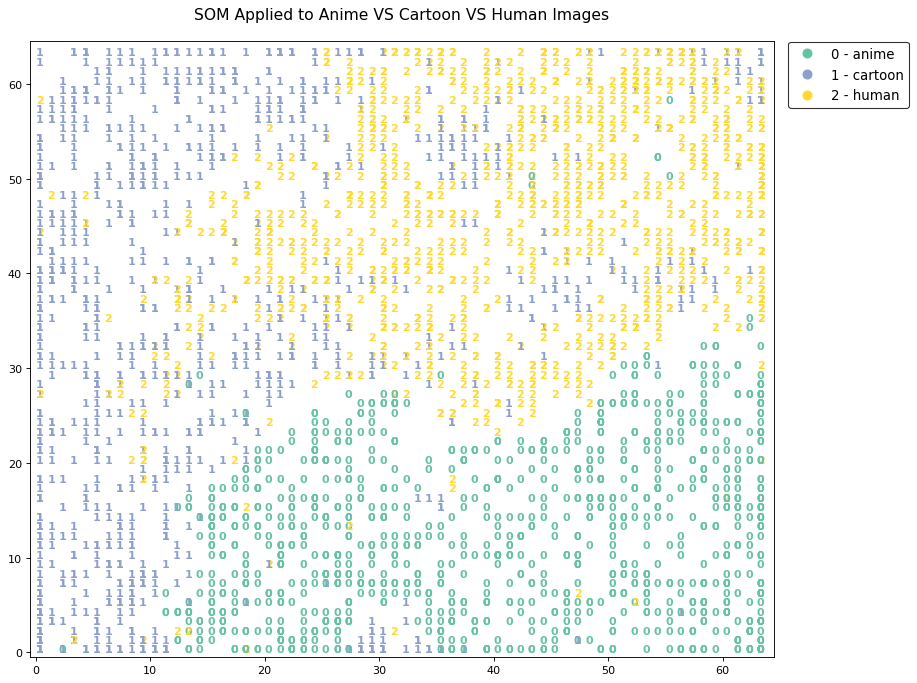

In [20]:
#Plot the image clustering using SOM model
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

#Take some batches of image data and plot the location with the corresponding label
for data, numbers in train_som.take(50).as_numpy_iterator():
    for sample,number in zip(data, numbers):
        winner = som_model.calculate_winner(sample)
        x_coordinate = winner[0]
        y_coordinate = winner[1]
        num_colors = plt.cm.Set2(number.argmax() / 3)
        plt.text(x_coordinate, y_coordinate,
                 str(number.argmax()), color=num_colors,
                 fontdict={'weight':'bold', 'size':10})

#Create a legend manually
import matplotlib.patches as patches   
colors = [plt.cm.Set2(i/3) for i in range(3)]
texts = ["0 - anime", "1 - cartoon", "2 - human"]
patches = [ plt.plot([],[],[], marker='o', ms=8, ls="", color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.01, 1.01), fontsize=12,
           loc='upper left', ncol=1, edgecolor="black", numpoints=1)

#Set limits of axes and the title
plt.ylim(-.5, 64.5)
plt.xlim(-.5, 64.5)
plt.title('SOM Applied to Anime VS Cartoon VS Human Images', fontsize=14, pad=20)
plt.show()


<h3>Conclusion

I only plotted 50 batches of data due to the time consumption. 
- Although this model was only trained with 200 iterations, the clustering was great overall. 
- Anime images and human images were grouped successfully with only few of them labeled incorrectly. 
- However, some of the cartoon images were clustered in other groups. 

I assume that this is beacuse of the images in cartoon dataset are not consistent as those in anime and human dataset.<br>
To illustrate, I want to show the images in the same group. 

<h3>Inspect images in different groups

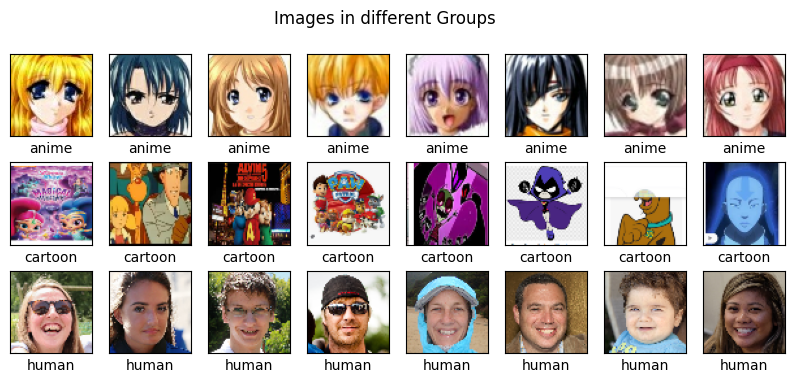

In [11]:
#Get second batch from the dataset pipeline
batch2 = train_iterator.next()

#Append images to corresponding lists
anime_list = []
cartoon_list = []
human_list = []
lists = [anime_list, cartoon_list, human_list]
for k in range(64):    
    if batch2[1][k].argmax()==0:
        anime_list.append(k)
    if batch2[1][k].argmax()==1:
        cartoon_list.append(k)
    if batch2[1][k].argmax()==2:
        human_list.append(k)
        
#Show some images with their labels in one train batch
fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(10,4))
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(batch2[0][lists[row][col]].astype(int), cmap=plt.cm.gray)
        #Get the index of the maximum value (1) and change it to the actual label name
        ax[row, col].set_xlabel(labels[batch2[1][lists[row][col]].argmax()], fontsize=10)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([]) 
plt.suptitle('Images in different Groups')
plt.show()

From the images above, we can see that the images in anime and human groups are all faces. On the other hand, the images in cartoon group are different. Some of them are full-body characters, whereas others have multiple characters. The inconsistent data would definitely affect the training of the model.

<h3>Apply SOM to the Test Dataset

<h4>Preprocess the test data

In [16]:
#Reshape the image data to an one-dimensional array
test_som = test.map(lambda X, y: (tf.reshape(X, [tf.shape(X)[0], -1]), y))

Since there are less images in the test data, all the batches are used for clustering.

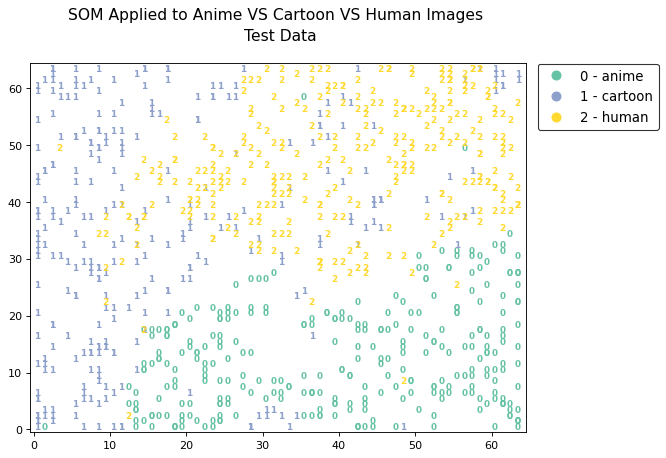

In [98]:
#Plot the test image clustering using SOM model
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

#Take all the batches (893/64) of image data and plot the location with the corresponding label
for data, numbers in test_som.take(14).as_numpy_iterator():
    for sample,number in zip(data, numbers):
        winner = som_model.calculate_winner(sample)
        x_coordinate = winner[0]
        y_coordinate = winner[1]
        num_colors = plt.cm.Set2(number.argmax() / 3)
        plt.text(x_coordinate, y_coordinate,
                 str(number.argmax()), color=num_colors,
                 fontdict={'weight':'bold', 'size':8})

#Create a legend manually
import matplotlib.patches as patches   
colors = [plt.cm.Set2(i/3) for i in range(3)]
texts = ["0 - anime", "1 - cartoon", "2 - human"]
patches = [ plt.plot([],[],[], marker='o', ms=8, ls="", color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.01, 1.015), fontsize=12,
           loc='upper left', ncol=1, edgecolor="black", numpoints=1)

#Set limits of axes and the title
plt.ylim(-.5, 64.5)
plt.xlim(-.5, 64.5)
plt.title('SOM Applied to Anime VS Cartoon VS Human Images \n Test Data',
          linespacing=1.5,fontsize=14, pad=20)

plt.show()

The SOM model did a great job clustering the test images as well, except for some cartoon images just as the training dataset.

<h2>IV: Image Generation Using Conditional GAN Model

This is the most difficult part of my project. In order to generate images based on different labels, I used <b>Conditional GAN</b> instead of the original GAN. Below are the references:

- https://www.tensorflow.org/tutorials/generative/dcgan
- https://keras.io/examples/generative/conditional_gan/
- https://www.youtube.com/watch?v=AALBGpLbj6Q
- https://pub.towardsai.net/a-beginners-guide-to-building-a-conditional-gan-d261e4d94882

<h4>Load dependencies

In [5]:
#!pip install -q git+https://github.com/tensorflow/docs
#!pip install imageio

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

<h4>Constants and hyperparameters

In [12]:
num_channels = 3
num_classes = 3
image_size = 64
latent_dim = 128

<h4>Preprocess Data

During may times of training and hyperparameter tuning, I found that it is better to use 32 as the batch size instead of 64. So I created the dataset pipeline again to make sure the batch size is optimal. The pipeline uses training data only since I don't need test data to train a GAN model.

In [13]:
#Generates tf.data.Dataset from image files in the train and test directory.
train_gan = tf.keras.utils.image_dataset_from_directory(
    train_directory, label_mode='categorical', shuffle=True,
    image_size=(64, 64), seed=1001, batch_size=32)

Found 8024 files belonging to 3 classes.


For GAN model, I will stick with the 64X64 pixels and 3 channels, but the pixel values cannot be \[0,255\]. Instead of normalizing the values to \[0,1\] and using Relu activation function, I normalize the values to \[-1, 1\] because I will use LeakyReLU as my activation function later. 

In [14]:
train_gan = train_gan.map(lambda X, y: (((X-127.5)/127.5), y))

In [15]:
#Check the data to see if the data is transformed correctly.
scaled_train_batch = train_gan.as_numpy_iterator().next()

print('The pixel values of images in the train set are between: [{} , {}]'.format(
    scaled_train_batch[0].min(), scaled_train_batch[0].max()))

The pixel values of images in the train set are between: [-1.0 , 1.0]


<h4>Show the shape of scaled training data again

In [16]:
#Show the shape of train data in a batch again
print('The length of the batch:', len(scaled_train_batch))
print('The shape of the images in the batch:', scaled_train_batch[0].shape)
print('The shape of the labels in the batch:', scaled_train_batch[1].shape)
print('The sample label data:', scaled_train_batch[1][0])

The length of the batch: 2
The shape of the images in the batch: (32, 64, 64, 3)
The shape of the labels in the batch: (32, 3)
The sample label data: [0. 0. 1.]


<h4>Calculating the number of input channel for the generator and discriminator

Add the number of classes to the input channels of the generator (noise input) as well as the discriminator (generated image input).

In [17]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print('The number of input channel for the generator:', generator_in_channels)
print('The number of input channel for the discriminator:', discriminator_in_channels)

The number of input channel for the generator: 131
The number of input channel for the discriminator: 6


<h3>Create the Discriminator

The discriminator will decide if an image is real (from the dataset) or fake (generated by the generator). As a conditional GAN, the information of class label is also included.

In [18]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        #Input shape is 64*64*6 (6 represents 3 channel of images + 3 classes in labels)
        keras.layers.InputLayer((64, 64, discriminator_in_channels)),
        
        #Conv2D block #1
        #Add a Conv2D layer with 64 filters, 4*4 kernel size, and stride length of 2
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
        #Add batch normalization to normalize inputs
        layers.BatchNormalization(),
        #Add a LeakyRelU layer as active function. 
        #Alpha indicates the negative slope coefficient
        layers.LeakyReLU(alpha=0.2),
        
        #Conv2D block #2
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        #Conv2D block #3
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        #Conv2D block #4
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        #Conv2D blodk #5
        #Use 1 filter to reduce params
        layers.Conv2D(1, (4, 4), padding='valid'),
        #Flatten the input
        layers.Flatten(),
        #Dense layer with one unit because the result would be 0 or 1 (fake or real)
        layers.Activation('sigmoid'),
    ],
    name="discriminator",
)

In [19]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        6208      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

<h3>Create the Generator

Generator takes random noise along with the conditional information as input and generates images. 

In [20]:
generator = keras.Sequential(
    [
        #Number of input channel is 131 (128 latent dimension + 3 classes of lables)
        keras.layers.InputLayer((generator_in_channels,)),
        
        #Beginnings of a generated image
        # Generate 128 + num_classes coefficients to reshape into a
        # 8x8x(128 + num_classes) map.
        layers.Dense(8 * 8 * generator_in_channels),
        #Add a LeakyRelU layer as active function. Alpha indicates the negative slope coefficient
        layers.LeakyReLU(alpha=0.2),
        #Reshape the inputs
        layers.Reshape((8, 8, generator_in_channels)),
             
        #Conv2D block using Conv2DTranspose 
        layers.Conv2DTranspose(512, (4, 4),padding="same"),
        #Add batch normalization to normalize inputs
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        #Upsampling block 1
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        #Upsampling block 2
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        #Upsampling block 3
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),


        #The final shape of the output should be the same as the size of the image (64x64x3)
        layers.Conv2D(3, (4, 4), padding="same", activation="tanh"),
    ],
    name="generator",
)

In [21]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8384)              1106688   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8384)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 131)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        1073664   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 512)         0 

<h3>Creating the ConditionalGAN Model

In [35]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    #Compile the model with attributes for losses and optimizers
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
        

<h3>Compile the Conditional GAN Model

In [36]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

<h3>Build Callbacks

<h4>Build a customized callback to monitor generated images

In [37]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [38]:
#Create a customized callback
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=generator_in_channels):
        self.num_img = num_img #Number of images to save for each epoch
        self.latent_dim = latent_dim

    #At the end of each epoch, convert generated numpy array into images and save to the preset path 
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GANImages', f'generated_img_{epoch}_{i}.png'))

During training, generated images will be saved in the folder "GANImages". By default, each epoch will generate 3 images.

<h4>Build checkpoint to save weights every epoch

Training this model on my personal computer is very challenging. Although I have a GPU with 12G memory, it seems not enough for this type of model. Sometimes it crashed during training and all the work was lost. In order to save my training progress, I used checkpoint to save the weights every epoch, so that I can start over from the last checkpoint I saved.

In [39]:
#Add a callback checkpoint to save the model weights 
checkpoint_filepath = './temp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq = 'epoch')

<h3>Train the Model with Customized Callbacks

In [40]:
cond_gan.fit(train_gan, epochs=100, callbacks=[ModelMonitor(), checkpoint_callback])

Epoch 1/100
251/251 [==============================] - 13s 40ms/step - g_loss: 3.0137 - d_loss: 0.4097
Epoch 2/100
251/251 [==============================] - 11s 40ms/step - g_loss: 1.1212 - d_loss: 0.5937
Epoch 3/100
251/251 [==============================] - 10s 38ms/step - g_loss: 0.9834 - d_loss: 0.6303
Epoch 4/100
251/251 [==============================] - 11s 43ms/step - g_loss: 0.9400 - d_loss: 0.6475
Epoch 5/100
251/251 [==============================] - 9s 35ms/step - g_loss: 0.9337 - d_loss: 0.6445
Epoch 6/100
251/251 [==============================] - 9s 36ms/step - g_loss: 0.9942 - d_loss: 0.6384
Epoch 7/100
251/251 [==============================] - 9s 35ms/step - g_loss: 0.9881 - d_loss: 0.6420
Epoch 8/100
251/251 [==============================] - 9s 35ms/step - g_loss: 1.0444 - d_loss: 0.6435
Epoch 9/100
251/251 [==============================] - 9s 35ms/step - g_loss: 1.0016 - d_loss: 0.6361
Epoch 10/100
251/251 [==============================] - 9s 36ms/step - g_loss:

If the training crashed or I want to add more epochs, I can continue to train the model from the last saved checkpoint.
My final model didn't crash with 100 epochs, so I didn't run the cell below.

In [ ]:
cond_gan.load_weights(checkpoint_filepath)
cond_gan.fit(train_gan, epochs=100, callbacks=[ModelMonitor(), checkpoint_callback])

<h3>Save and Load the Final Model</h3>

I only save the generator because this is the only part I need to generate images.

In [41]:
cond_gan.generator.save('cGAN.h5')

In [42]:
gan_model = keras.models.load_model('cGAN.h5', compile=False)

<h3>Show Generated Images</h3>

<h4>Interpolating between classes with the trained generator

In [85]:
# Extract the trained generator from the Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 11  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:2, step:1}
end_class = 2  # @param {type:"slider", min:0, max:2, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 0s 21ms/step


<h4>GIF for selected classes</h4>

I selected two labels (anime and human) to generate images and show with an animated GIF.


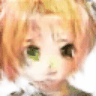

In [86]:
#Convert the value back to 0-255 and create a gif file
fake_images = fake_images * 127.5 + 127.5
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

<h4>Functions for generating noise with class label and plot images</h4>

In [87]:
def noise_with_class_label(class_number):
    one_hot_labels = keras.utils.to_categorical(class_number, num_classes)[None,:]
    random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
    random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1)
    return random_vector_labels

In [218]:
# Generate images from the generator
def plot_images(class_number):
    class_number = class_number
    num_classes = 3
    latent_dim = 128
    img = []
    labels = ['Anime', 'Cartoon', 'Human']
    for i in range(6):
        image = gan_model.predict(noise_with_class_label(class_number), verbose=0)
        img.append((image * 127.5 + 127.5).astype(np.uint8))
    # Setup the subplot formatting 
    fig, ax = plt.subplots(ncols=6, figsize=(8,2))
    # Loop four times and get images 
    for idx, img in enumerate(img): 
        # Plot the image using a specific subplot 
        ax[idx].imshow(np.squeeze(img))
        # Appending the image label as the plot title 
        ax[idx].title.set_text(idx+1)
        ax[idx].axis('off')
    plt.suptitle('Generated Fake Images: {}'.format(labels[class_number]), 
                 y=1, fontsize=15)
    plt.show()

<h4>Generated images by class</h4>

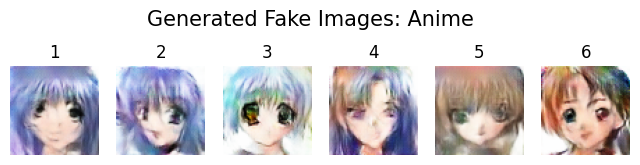

In [219]:
plot_images(0)

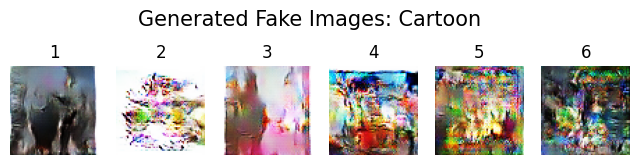

In [220]:
plot_images(1)

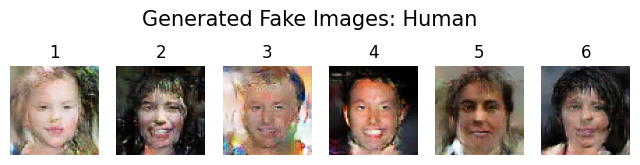

In [224]:
plot_images(2)

These images above are the results of my conditional GAN model trained with 100 epochs. Just as I expected, the quality of anime and human images are way better than cartoon images. I inspected images in different groups when clustering with SOM model. Due to the variety of cartoon images, it is hard for the model to learn a specific pattern from the data. 

<h4>Show some best generated images during training</h4>

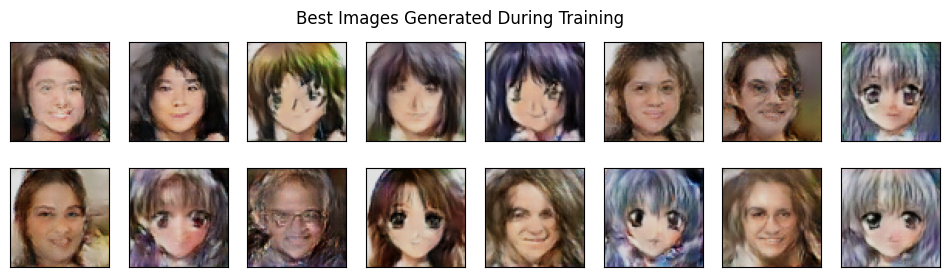

In [207]:
from matplotlib.image import imread
img_list = os.listdir('best_images')
best_img = []
for img in img_list:
    image = imread('best_images/'+ img)
    best_img.append((image * 225))
plt.imshow
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for r in range(2):
    for c in range(8):
        ax[r, c].imshow(((best_img[r*8+c])).astype(int))
        #Get the index of the maximum value (1) and change it to the actual label name
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([]) 
plt.suptitle('Best Images Generated During Training')
plt.show()

The customized callback monitored generated images during training. I picked some best images from multiple rounds of trainings with different hyperparameters. It is interesting that one of the human images seems to wear glasses, and most of them have smiley faces. 

<h2>Conclusion</h2>

For this project, I created an SOM model for clustering different types of images (anime, cartoon, human), and a conditional GAN model to generate images with different labels.

- The SOM model clustered anime and human images successfully with only a few of them labeled incorrectly.
- The conditional GAN model generates anime and human images better than cartoon images.
- Due to the variety of cartoon images, it is difficult to cluster them as a group. Similarly, it is difficult to generate this type of image as well.
- The callbacks helped me very much during the training of GAN model. I can monitor the progress of image generation simultaneously and can also load the work from the checkpoint if something goes wrong.
- Although the code for my model deployment is not included in this notebook, I did a lot of work to make my model show the result perfectly.
- Unforturnately, the free memory of 512MB on Render is not enough for the model. If you try too many times on the website, the server will crash because it ran out of memory. You may need to wait and try again later.

In [ ]:
keras.models.